# Autoregressive (AR) HMM Demo

This notebook illustrates the use of the _auto_regression_ observation model.  
Let $x_t$ denote the observation at time $t$. Let $z_t$ denote the corresponding discrete latent state.

The autoregressive hidden Markov model has the following likelihood,
$$
\begin{align}
x_t \mid x_{t-1}, z_t &\sim
\mathcal{N}\left(A_{z_t} x_{t-1} + b_{z_t}, Q_{z_t} \right).
\end{align}
$$
(Technically, higher-order autoregressive processes with extra linear terms from inputs are also implemented.) 

In [1]:
import jax.numpy as jnp

import jax.random as jr

from tensorflow_probability.substrates import jax as tfp

import warnings
warnings.filterwarnings("ignore")  # TFP throws some annoying "check_types" warnings

from ssm_jax.hmm.models.autoregressive_hmm import LinearAutoregressiveHMM
from ssm_jax.plotting import gradient_cmap
from ssm_jax.utils import random_rotation
# from ssm.plots import gradient_cmap #, white_to_color_cmap

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]


colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

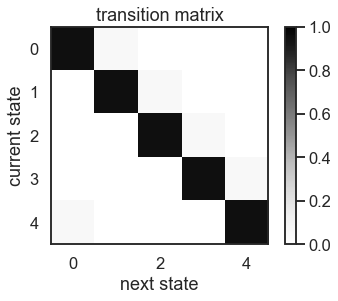

In [3]:
# Make a transition matrix
num_states = 5
transition_probs = (jnp.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = jnp.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += jnp.roll(p * jnp.eye(num_states), k, axis=1)
    
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

In [4]:
# Make observation distributions
emission_dim = 2
num_lags = 1

keys = jr.split(jr.PRNGKey(0), num_states)
angles = jnp.linspace(0, 2 * jnp.pi, num_states, endpoint=False)
theta = jnp.pi / 25 # rotational frequency
weights = jnp.array([0.8 * random_rotation(key, emission_dim, theta=theta) for key in keys])
biases = jnp.column_stack([jnp.cos(angles), jnp.sin(angles), jnp.zeros((num_states, emission_dim - 2))])
covariances = jnp.tile(0.001 * jnp.eye(emission_dim), (num_states, 1, 1))

# Compute the stationary points
stationary_points = jnp.linalg.solve(jnp.eye(emission_dim) - weights, biases)

# Plot dynamics functions

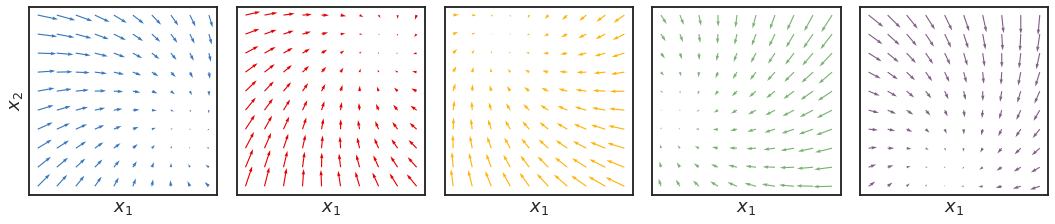

In [5]:
if emission_dim == 2:
    lim = 5
    x = jnp.linspace(-lim, lim, 10)
    y = jnp.linspace(-lim, lim, 10)
    X, Y = jnp.meshgrid(x, y)
    xy = jnp.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k in range(num_states):
        A, b = weights[k], biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('$x_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("$x_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
                        

    plt.tight_layout()

# Sample emissions from the ARHMM

In [6]:
# Make an Autoregressive (AR) HMM
true_arhmm = LinearAutoregressiveHMM(
    initial_probabilities=jnp.ones(num_states) / num_states,
    transition_matrix=transition_matrix,
    emission_matrices=weights,
    emission_biases=biases,
    emission_covariance_matrices=covariances)

time_bins = 10000
true_states, emissions, features = true_arhmm.sample(jr.PRNGKey(0), time_bins)

Text(0, 0.5, '$x_2$')

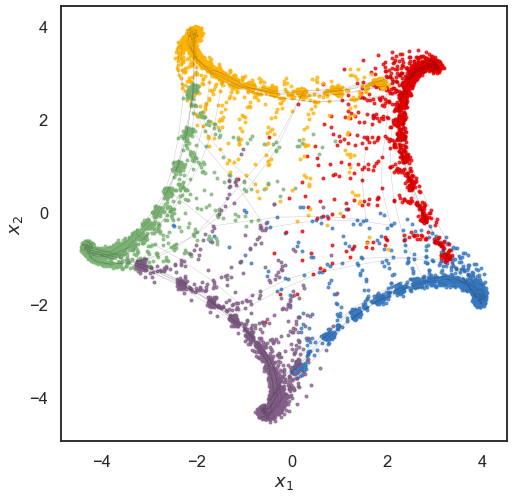

In [7]:
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*emissions[true_states==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*emissions[:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
# plt.gca().set_aspect("equal")

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the stationary point of the the corresponding AR state while the solid lines are the actual observations sampled from the HMM.

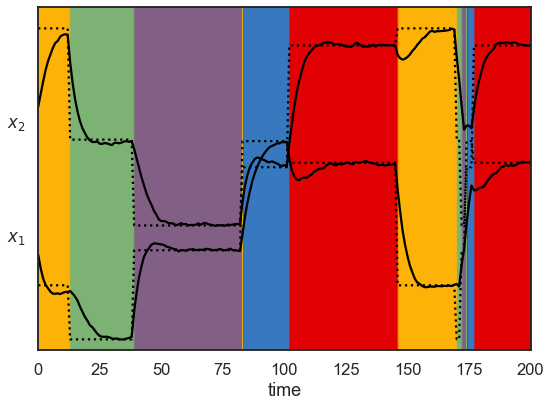

In [8]:
# Plot the emissions and the smoothed emissions
plot_slice = (0, 200)
lim = 1.05 * abs(emissions).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (emission_dim)*lim))


Ey = jnp.array(stationary_points)[true_states]
for d in range(emission_dim):
    plt.plot(emissions[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(plot_slice)
plt.xlabel("time")
plt.yticks(lim * jnp.arange(emission_dim), ["$x_{{{}}}$".format(d+1) for d in range(emission_dim)])

plt.tight_layout()


# Fit an ARHMM

In [9]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)
test_num_states = num_states

arhmm = LinearAutoregressiveHMM.random_initialization(
    jr.PRNGKey(1),
    test_num_states,
    emission_dim,
    num_lags,)

lps = arhmm.fit_em(jnp.expand_dims(emissions, 0), features=jnp.expand_dims(features, 0))

100%|██████████| 50/50 [00:01<00:00, 28.31it/s]


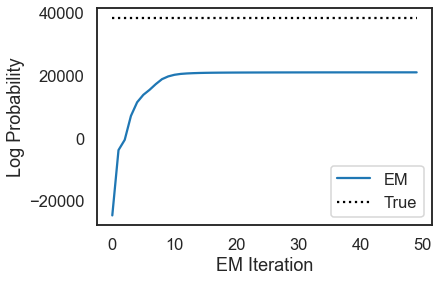

In [10]:
# Plot the log likelihoods against the true likelihood, for comparison
true_lp = true_arhmm.marginal_log_prob(emissions, features=features)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [12]:
# # Find a permutation of the states that best matches the true and inferred states
# most_likely_states = posterior.most_likely_states()
# arhmm.permute(find_permutation(true_states[num_lags:], most_likely_states))
# posterior.update()
# most_likely_states = posterior.most_likely_states()
posterior = arhmm.smoother(emissions, features=features)
most_likely_states = arhmm.most_likely_states(emissions, features=features)

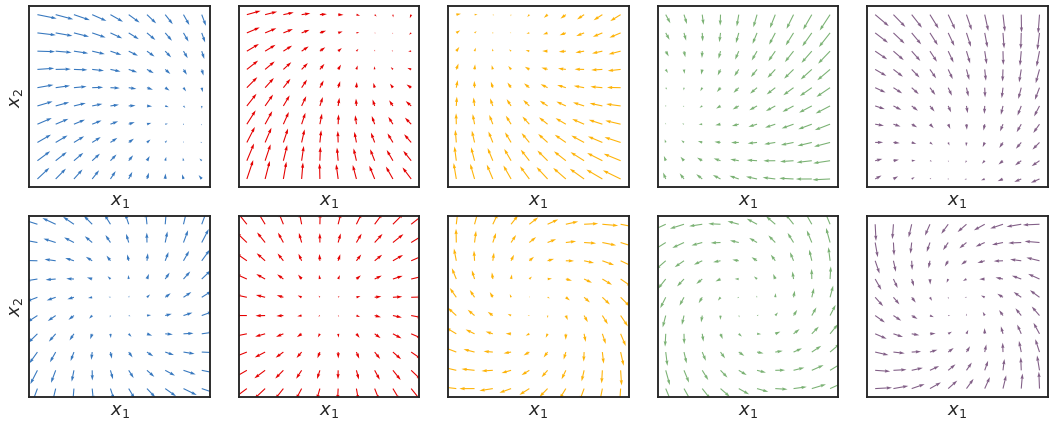

In [14]:
if emission_dim == 2:
    lim = abs(emissions).max()
    x = jnp.linspace(-lim, lim, 10)
    y = jnp.linspace(-lim, lim, 10)
    X, Y = jnp.meshgrid(x, y)
    xy = jnp.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(2, max(num_states, test_num_states), figsize=(3 * num_states, 6))
    for i, model in enumerate([true_arhmm, arhmm]):
        for j in range(model.num_states):
            A = model.emission_matrices.value[j]
            b = model.emission_biases.value[j]
            dxydt_m = xy.dot(A.T) + b - xy
            axs[i,j].quiver(xy[:, 0], xy[:, 1],
                        dxydt_m[:, 0], dxydt_m[:, 1],
                        color=colors[j % len(colors)])


            axs[i,j].set_xlabel('$x_1$')
            axs[i,j].set_xticks([])
            if j == 0:
                axs[i,j].set_ylabel("$x_2$")
            axs[i,j].set_yticks([])
            axs[i,j].set_aspect("equal")
                        

    plt.tight_layout()

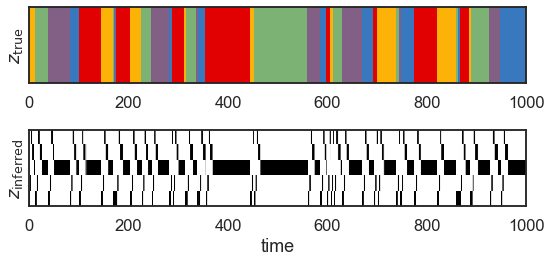

In [13]:
# Plot the true and inferred discrete states
plot_slice = (0, 1000)
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_states[None,num_lags:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
# plt.imshow(most_likely_states[None,: :], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [14]:
# Sample the fitted model
sampled_states, sampled_emissions, _ = arhmm.sample(jr.PRNGKey(0), time_bins)

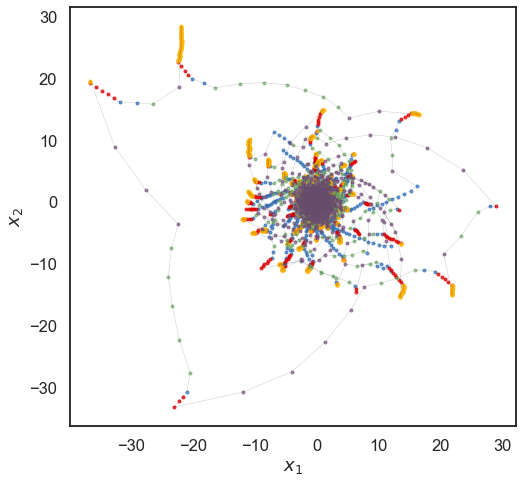

In [15]:
fig = plt.figure(figsize=(8, 8))
for k in range(test_num_states):
    plt.plot(*sampled_emissions[sampled_states==k].T, 'o', color=colors[k % len(colors)],
         alpha=0.75, markersize=3)
    
plt.plot(*sampled_emissions.T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal")